In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import os

In [2]:
trades = pd.read_csv("historical_data.csv")
fg = pd.read_csv("fear_greed_index.csv")
os.makedirs("results", exist_ok=True)

In [3]:
trades.rename(columns={
    "Account": "account",
    "Execution Price": "price",
    "Closed PnL": "pnl",
    "Timestamp IST": "time"
}, inplace=True)

trades["time"] = pd.to_datetime(trades["time"], utc=True)
trades["date"] = trades["time"].dt.date
trades["pnl"] = pd.to_numeric(trades["pnl"], errors="coerce").fillna(0)


In [6]:
fg["date"] = pd.to_datetime(fg["date"]).dt.date
fg.rename(columns={"date": "date", "classification": "sent_class"}, inplace=True)

sent_map = {
    "Extreme Fear": 0,
    "Fear": 25,
    "Neutral": 50,
    "Greed": 75,
    "Extreme Greed": 100
}
fg["sentiment"] = fg["sent_class"].map(sent_map)
fg["sentiment"] = fg["sentiment"].interpolate().ffill().bfill()


In [7]:
daily = trades.groupby(["account", "date"]).agg(
    trades_count=("pnl", "count"),
    gross_pnl=("pnl", "sum"),
    avg_pnl=("pnl", "mean")
).reset_index()

merged = daily.merge(fg[["date", "sentiment"]], on="date", how="left")
merged["sentiment"] = merged["sentiment"].ffill().bfill()
merged.to_csv("results/merged_account_daily.csv", index=False)

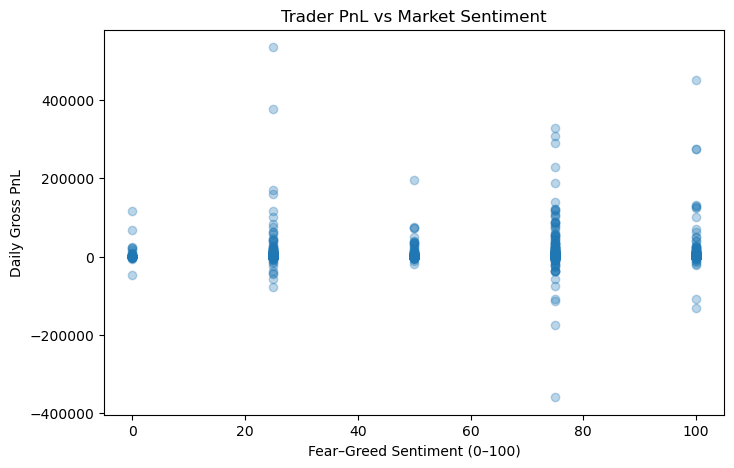

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(merged["sentiment"], merged["gross_pnl"], alpha=0.3)
plt.xlabel("Fear–Greed Sentiment (0–100)")
plt.ylabel("Daily Gross PnL")
plt.title("Trader PnL vs Market Sentiment")
plt.savefig("results/pnl_vs_sentiment.png")
#plt.close()
plt.show()


In [11]:
X = sm.add_constant(merged[["sentiment", "trades_count"]])
y = merged["gross_pnl"]
ols = sm.OLS(y, X).fit(cov_type="HC3")

with open("results/ols_summary.txt", "w") as f:
    f.write(ols.summary().as_text())

In [12]:
merged["sent_bin"] = pd.cut(
    merged["sentiment"], [0,20,40,60,80,100],
    labels=["ExtFear","Fear","Neutral","Greed","ExtGreed"]
)

groups = [g["gross_pnl"].values for _, g in merged.groupby("sent_bin") if len(g) > 10]
anova = stats.f_oneway(*groups)
print("ANOVA p-value:", anova.pvalue)

ANOVA p-value: 0.6138135419476556


In [13]:
features = trades.groupby("account").agg(
    total_pnl=("pnl", "sum"),
    mean_pnl=("pnl", "mean"),
    trade_count=("pnl", "count")
).reset_index()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features[["total_pnl", "mean_pnl", "trade_count"]])

kmeans = KMeans(n_clusters=5, random_state=42)
features["cluster"] = kmeans.fit_predict(X_scaled)
features.to_csv("results/trader_clusters.csv", index=False)

print("✅ Analysis complete. Results saved in /results folder.")

c:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


✅ Analysis complete. Results saved in /results folder.
